Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf), Chapter 8
  - _**[Gradient Boosting Explained](https://www.gormanalysis.com/blog/gradient-boosting-explained/)**_ — Ben Gorman
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) — Alex Rogozhnikov
  - [How to explain gradient boosting](https://explained.ai/gradient-boosting/) — Terence Parr & Jeremy Howard

In [50]:
#library versions
!pip install -U scikit-learn
!python -m pip show scikit-learn


Requirement already up-to-date: scikit-learn in /Users/johnrivera/.virtualenvs/jupyter/lib/python3.7/site-packages (0.23.1)
Name: scikit-learn
Version: 0.23.1
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: None
Author-email: None
License: new BSD
Location: /Users/johnrivera/.virtualenvs/jupyter/lib/python3.7/site-packages
Requires: numpy, scipy, joblib, threadpoolctl
Required-by: sklearn, eli5, category-encoders


In [51]:
#importing data
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/JonRivera/JonRivera.github.io/master/Unit2/Buil_Week/Data_Sets/Hotel_Bookings/hotel_bookings.csv")

In [52]:
df.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [54]:
def wrangle(df):
    df = df.copy()
    #drop unecessary columns, or columns that seem to have little impact on target
    df = df.drop(['company', 'agent','arrival_date_week_number'],axis = 1)
    df = df.dropna(axis=0)  
    #set date column to index
    #doesn't add any substantial info, and has high cardinality. 
    #arrivate_date year,month, day already include this info ..
    df.set_index(pd.to_datetime(df['reservation_status_date']), inplace = True)
    df = df.drop(['reservation_status_date'], axis=1)
    #I am treating cancelations as people who canceled or did not show
    #on there arrival date --- it was assumend the hotel would cancel there stay 
    
    df['reservation_status'] =  df['reservation_status'].replace({'No-Show':'Canceled'})
    return df
df = wrangle(df)


In [55]:
#get train, validate,and test subsets
train = df[df['arrival_date_year']==2015].copy()
val = df[df['arrival_date_year']==2016].copy()
test = df[df['arrival_date_year'] == 2017].copy()
train.shape, val.shape, test.shape

((21859, 28), (56435, 28), (40604, 28))

In [56]:
train.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status
reservation_status_date,,,,,,,,,,,,,,,,,,,,,
2015-07-01,Resort Hotel,0,342,2015,July,1,0,0,2,0.0,...,C,C,3,No Deposit,0,Transient,0.0,0,0,Check-Out
2015-07-01,Resort Hotel,0,737,2015,July,1,0,0,2,0.0,...,C,C,4,No Deposit,0,Transient,0.0,0,0,Check-Out
2015-07-02,Resort Hotel,0,7,2015,July,1,0,1,1,0.0,...,A,C,0,No Deposit,0,Transient,75.0,0,0,Check-Out
2015-07-02,Resort Hotel,0,13,2015,July,1,0,1,1,0.0,...,A,A,0,No Deposit,0,Transient,75.0,0,0,Check-Out
2015-07-03,Resort Hotel,0,14,2015,July,1,0,2,2,0.0,...,A,A,0,No Deposit,0,Transient,98.0,0,1,Check-Out


In [57]:
train.describe(exclude='number')

,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type,reservation_status
count,21859,21859,21859,21859,21859,21859,21859,21859,21859,21859,21859
unique,2,6,5,98,6,5,9,11,3,4,2
top,City Hotel,September,BB,PRT,Online TA,TA/TO,A,A,No Deposit,Transient,Check-Out
freq,13663,5084,17106,13303,6148,17691,17614,14376,18202,11319,13753


In [58]:
#feature selection
# is_canceled is also a target vector, reveals reservation_status implicitly ... is leaking information of target
def features_select(df):    
    target = 'reservation_status'
    #creating subsets of features, splitted between numerical and categorical
    train_features =  df.drop(columns = [target, 'is_canceled'],axis =1)
    numeric_features = train_features.select_dtypes(include='number').columns.tolist()
    cardinality = train_features.select_dtypes(exclude = 'number').nunique()
    categorical_features = cardinality.index.tolist()
    #combine lists to extrapolate features of interest
    features = numeric_features + categorical_features
    return features
features = features_select(df)
features

['lead_time',
 'arrival_date_year',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'hotel',
 'arrival_date_month',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'assigned_room_type',
 'deposit_type',
 'customer_type']

In [59]:
#def feature_engineering(X):

In [60]:
#seperating X matrices and correspind y vectors
target = 'reservation_status'
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]
X_val= val[features]
y_val = val[target]
X_train.shape,y_train.shape,X_val.shape, y_val.shape

((21859, 26), (21859,), (56435, 26), (56435,))

In [61]:
#baselines
y_train.value_counts(normalize=True)


Check-Out    0.629169
Canceled     0.370831
Name: reservation_status, dtype: float64

##Permuation Importance

In [62]:
y_val.value_counts(normalize=True)


Check-Out    0.640064
Canceled     0.359936
Name: reservation_status, dtype: float64

Build Model

In [63]:
#instantitate classes
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV

In [64]:
#Build pipeline using RadnomSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
model0 = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(n_jobs = -1, random_state=40)

)

param_distributions = { 
    'randomforestclassifier__n_estimators': [100],
    'randomforestclassifier__criterion': ['gini', 'entropy'],
    'randomforestclassifier__max_features': [5,10,20],
    'randomforestclassifier__min_samples_split': [5,10,15,20],
    'randomforestclassifier__min_samples_leaf': [2]
}
search = RandomizedSearchCV(
    pipeline, 
    param_distributions = param_distributions,
    n_iter = 10,
    cv=10,
    scoring ='accuracy',
    verbose = 1,
    return_train_score = True,
    n_jobs = -1
)

search.fit(X_train, y_train)
print('Cross-validation Best Score', search.best_score_)
print('Best Estimator:' ,search.best_params_)
print('Best Model', search.best_estimator_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.7min finished


Cross-validation Best Score 0.8336661216269121
Best Estimator: {'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__min_samples_split': 15, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__max_features': 5, 'randomforestclassifier__criterion': 'gini'}
Best Model Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['hotel', 'arrival_date_month', 'meal',
                                      'country', 'market_segment',
                                      'distribution_channel',
                                      'reserved_room_type',
                                      'assigned_room_type', 'deposit_type',
                                      'customer_type'],
                                mapping=[{'col': 'hotel',
                                          'data_type': dtype('O'),
                                          'mapping': Resort Hotel    1
City Hotel      2
NaN            -2
dtype: int64},
                

In [65]:
model0 = search.best_estimator_

In [66]:
model0.fit(X_train,y_train)


Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['hotel', 'arrival_date_month', 'meal',
                                      'country', 'market_segment',
                                      'distribution_channel',
                                      'reserved_room_type',
                                      'assigned_room_type', 'deposit_type',
                                      'customer_type'],
                                mapping=[{'col': 'hotel',
                                          'data_type': dtype('O'),
                                          'mapping': Resort Hotel    1
City Hotel      2
NaN            -2
dtype: int64},
                                         {'col': 'arrival_date_month',
                                          'data_type...
                                          'data_type': dtype('O'),
                                          'mapping': No Deposit    1
Refundable    2
Non Refund    3
NaN          -2
dtype: in

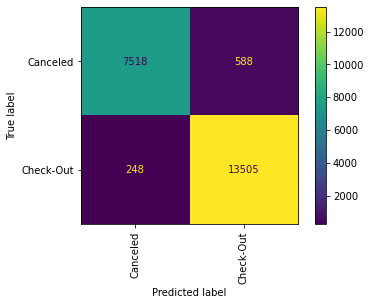

In [67]:
plot_confusion_matrix(model0, X_train, y_train, values_format='.0f', xticks_rotation='vertical')

In [69]:
y_pred0 = model0.predict(X_val)

In [70]:
print(classification_report(y_val, y_pred0))

              precision    recall  f1-score   support

    Canceled       0.90      0.42      0.58     20313
   Check-Out       0.75      0.97      0.85     36122

    accuracy                           0.78     56435
   macro avg       0.83      0.70      0.71     56435
weighted avg       0.81      0.78      0.75     56435



In [71]:
y_pred_probab0 = model0.predict_proba(X_val_encoded)
y_pred_probab0

array([[0.49789611, 0.50210389],
       [0.139125  , 0.860875  ],
       [0.22160609, 0.77839391],
       ...,
       [0.44762588, 0.55237412],
       [0.29538334, 0.70461666],
       [0.29538334, 0.70461666]])

In [72]:
roc_auc_score(y_val,y_pred_probab0[:,1])

0.7369633584712085

In [73]:
!pip install xgboost
from xgboost import XGBClassifier

Model Importances

In [74]:
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance


Feature Selection

In [75]:
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

model1 = XGBClassifier(
        n_estimators = 100,
        max_depth = 10,
        learning_rate = .5,
        n_jobs = -1

)

eval_set = [(X_train_encoded,y_train),
           (X_val_encoded,y_val)]
model1.fit(X_train_encoded, y_train,
         eval_set = eval_set,
          eval_metric = 'auc',
          early_stopping_rounds = 100)

[0]	validation_0-auc:0.97697	validation_1-auc:0.75036
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.98186	validation_1-auc:0.74739
[2]	validation_0-auc:0.98390	validation_1-auc:0.74836
[3]	validation_0-auc:0.98705	validation_1-auc:0.75373
[4]	validation_0-auc:0.98846	validation_1-auc:0.75322
[5]	validation_0-auc:0.98972	validation_1-auc:0.75518
[6]	validation_0-auc:0.99040	validation_1-auc:0.77184
[7]	validation_0-auc:0.99128	validation_1-auc:0.76614
[8]	validation_0-auc:0.99176	validation_1-auc:0.76803
[9]	validation_0-auc:0.99217	validation_1-auc:0.76704
[10]	validation_0-auc:0.99242	validation_1-auc:0.76927
[11]	validation_0-auc:0.99355	validation_1-auc:0.78266
[12]	validation_0-auc:0.99389	validation_1-auc:0.78426
[13]	validation_0-auc:0.99455	validation_1-auc:0.78772
[14]	validation_0-auc:0.99499	validation_1-auc:0.79048
[15]	validation_0-auc:0.995

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.5, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [93]:
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance
permuter = PermutationImportance(
    model,
    scoring = 'accuracy',
    n_iter= 5,
    random_state = 42
    )
permuter.fit(X_val_encoded,y_val)

PermutationImportance(estimator=Pipeline(steps=[('ordinalencoder',
                                                 OrdinalEncoder(cols=['hotel',
                                                                      'arrival_date_month',
                                                                      'meal',
                                                                      'country',
                                                                      'market_segment',
                                                                      'distribution_channel',
                                                                      'reserved_room_type',
                                                                      'assigned_room_type',
                                                                      'deposit_type',
                                                                      'customer_type'],
                                                               

In [95]:
permuter.feature_importances_
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names)

lead_time                         0.013743
arrival_date_year                 0.000000
arrival_date_day_of_month         0.001428
stays_in_weekend_nights          -0.000592
stays_in_week_nights             -0.007261
adults                            0.002428
children                          0.000652
babies                            0.000032
is_repeated_guest                -0.000298
previous_cancellations            0.029071
previous_bookings_not_canceled    0.003285
booking_changes                   0.009646
days_in_waiting_list              0.000620
adr                               0.007141
required_car_parking_spaces       0.004859
total_of_special_requests         0.025208
hotel                             0.000000
arrival_date_month                0.000000
meal                              0.000000
country                           0.000000
market_segment                    0.000000
distribution_channel              0.000000
reserved_room_type                0.000000
assigned_ro

In [96]:
#based on this we can see what columns are best to drop
eli5.show_weights(
    permuter,
    top=None, # shows permutation importances of all features
    feature_names = feature_names

)

Weight,Feature
0.0291 ± 0.0010,previous_cancellations
0.0252 ± 0.0014,total_of_special_requests
0.0137 ± 0.0015,lead_time
0.0096 ± 0.0010,booking_changes
0.0071 ± 0.0022,adr
0.0049 ± 0.0004,required_car_parking_spaces
0.0033 ± 0.0005,previous_bookings_not_canceled
0.0024 ± 0.0008,adults
0.0014 ± 0.0011,arrival_date_day_of_month
0.0007 ± 0.0006,children


In [76]:
y_pred1 = model1.predict(X_val_encoded)


Eval_Metrics


In [77]:
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

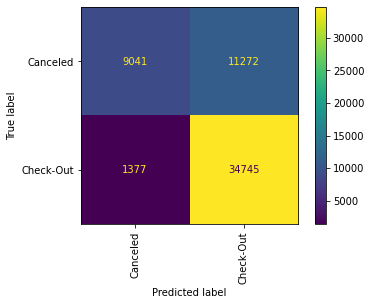

In [78]:
plot_confusion_matrix(model1, X_val_encoded, y_val, values_format='.0f', xticks_rotation='vertical');

In [79]:
print(classification_report(y_val, y_pred1))

              precision    recall  f1-score   support

    Canceled       0.87      0.45      0.59     20313
   Check-Out       0.76      0.96      0.85     36122

    accuracy                           0.78     56435
   macro avg       0.81      0.70      0.72     56435
weighted avg       0.80      0.78      0.75     56435



In [80]:
y_pred_probab1 = model1.predict_proba(X_val_encoded)

In [81]:
roc_auc_score(y_val,y_pred_probab1[:,1])

0.8121831082335602

In [82]:
accuracy_score(y_val,y_pred1)

0.7758660405776557

In [83]:
probs = model1.predict_proba(X_val_encoded)
probs

array([[2.1691918e-03, 9.9783081e-01],
       [5.3578615e-04, 9.9946421e-01],
       [2.9221773e-02, 9.7077823e-01],
       ...,
       [6.9177151e-04, 9.9930823e-01],
       [1.2081265e-03, 9.9879187e-01],
       [1.2081265e-03, 9.9879187e-01]], dtype=float32)

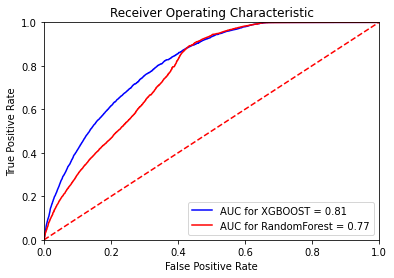

In [91]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs1 = model1.predict_proba(X_val_encoded)
preds1 = probs1[:,1]
fpr1, tpr1, threshold = metrics.roc_curve(y_val, preds1, pos_label='Check-Out')
roc_auc1 = metrics.auc(fpr1, tpr1)

probs0 = model0.predict_proba(X_val)
preds0 = probs0[:,1]
fpr0, tpr0, threshold = metrics.roc_curve(y_val, preds0, pos_label ='Check-Out')
roc_auc0 = metrics.auc(fpr0, tpr0)


# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr1, tpr1, 'b', label = 'AUC for XGBOOST = %0.2f' % roc_auc1)
plt.plot(fpr0, tpr0, 'r', label = 'AUC for RandomForest = %0.2f' % roc_auc0)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
#.81 AUC before feature selection based on feature importances